In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
projects <- c("CESC", "UCS", "UCEC")

In [3]:
# text_size <- 11
text_size <- 8
guide_size <- 1
# family <- "arial"
family <- "ArialMT"
dpi <- 320
ht <- 8
wd_1 <- 5
wd_2 <- 3

In [4]:
# p_thresh <- 0.05
q_thresh <- 0.05

In [5]:
demg_lists <- list()
survival_umsmg_lists <- list()
for (dset_idx in 1:3) {
    demg_lists[[projects[dset_idx]]] <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
    survival_umsmg_lists[[projects[dset_idx]]] <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_umsmg_list.txt"))
}


In [6]:
univ_dfs <- list()
cts_dfs <- list()
en_cph_dfs <- list()
for (dset_idx in 1:3) {
    univ_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_univ_survival_results.tsv")) %>%
        filter(geneID %in% demg_lists[[projects[dset_idx]]]) %>%
        filter(km_qval < q_thresh | cph_qval < q_thresh)
    
    cts_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_survival_cts_results.tsv")) %>%
        filter(geneID %in% demg_lists[[projects[dset_idx]]]) %>%
        filter(vital_qval < q_thresh)

    en_cph_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_cph_results.tsv")) %>%
#         filter(geneID %in% survival_umsmg_lists[[projects[dset_idx]]]) %>%
        filter(geneID %in% demg_lists[[projects[dset_idx]]])
}


-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  km_pval = col_double(),
  km_qval = col_double(),
  cph_pval = col_double(),
  cph_qval = col_double(),
  coeff = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  vital_pval = col_double(),
  vital_qval = col_double(),
  hr = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  coeff = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  km_pval = col_double(),
  km_qval = col_double(),
  cph_pval = col_double(),
  cph_qval = col_double(),
  co

In [7]:
univ_gene_list <- purrr::map(univ_dfs, "geneID") %>% unlist()
cts_gene_list <- purrr::map(cts_dfs, "geneID") %>% unlist()
en_cph_gene_list <- purrr::map(en_cph_dfs, "geneID") %>% unlist()
vis_gene_list <- univ_gene_list %>%
    union(cts_gene_list) %>%
    union(en_cph_gene_list)

In [8]:
length(vis_gene_list)

[1] 76

# Prognostic significance

In [9]:
surv_df <- tibble(geneID = vis_gene_list)
for (dset_idx in 1:3) {
    univ_col <- paste0(projects[dset_idx], "_univ")
    en_col <- paste0(projects[dset_idx], "_en")
    surv_df <- surv_df %>%
        mutate(
            !!as.name(univ_col) := geneID %in% univ_dfs[[projects[dset_idx]]]$geneID | geneID %in% cts_dfs[[projects[dset_idx]]]$geneID,
#             !!as.name(univ_col) := geneID %in% univ_dfs[[projects[dset_idx]]]$geneID,
            !!as.name(en_col) := geneID %in% en_cph_dfs[[projects[dset_idx]]]$geneID
        )
}

surv_df <- surv_df %>%
    mutate(checks = rowSums(.[-1])) %>%
    select(geneID, checks, CESC_en, CESC_univ, UCEC_en, UCEC_univ, UCS_en, UCS_univ) %>%
    mutate(last_true = max.col(.[,-c(1:2)], "last")) %>%
    arrange(checks, desc(last_true), desc(geneID)) %>%
    mutate(geneID_f = factor(geneID, levels = geneID)) %>%
    select(geneID_f, last_true, everything())

In [10]:
hm_surv_df <- surv_df %>%
    pivot_longer(cols = colnames(.[-c(1:4)]), names_to = "sig_list") %>%
    mutate(value = ifelse(value == TRUE, "yes", "no"), value = factor(value, levels = c("yes", "no")))
# head(hm_surv_df)

In [11]:
unique_sig_list <- unique(hm_surv_df$sig_list)
analysis_labs <- gsub("univ", "UV", gsub("en", "MV", gsub("_", " ", unique_sig_list)))
names(analysis_labs) <- unique_sig_list

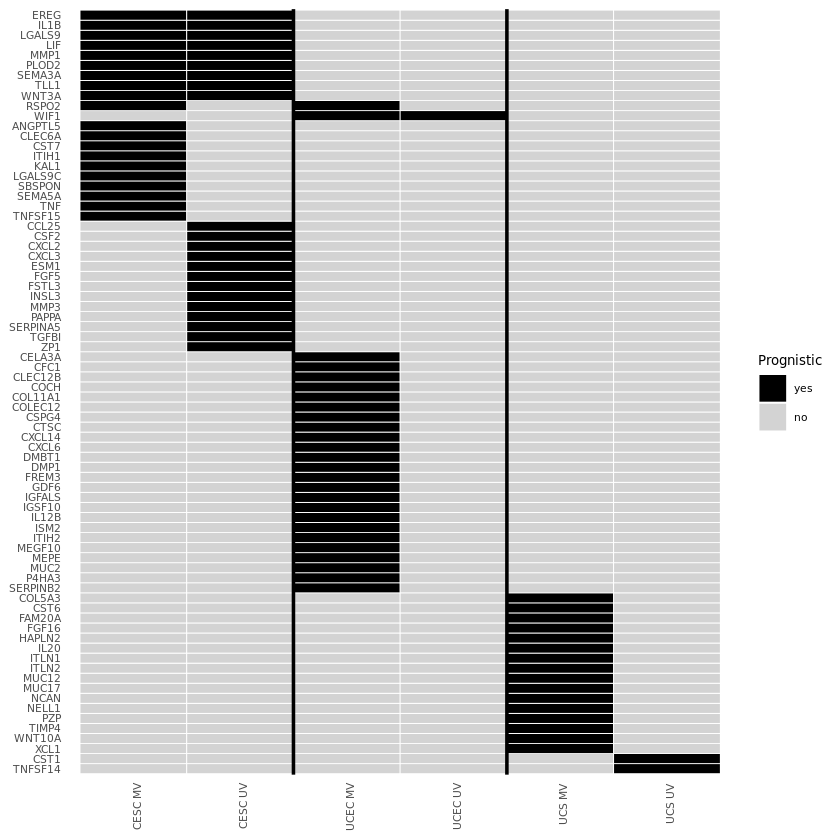

In [12]:
ggplot(hm_surv_df) +
    geom_tile(aes(x = sig_list, y = geneID_f, fill = value), color = "white", size = 0.25) +
    geom_vline(xintercept = c(2.5, 4.5), color = "black", size = 1) +
    scale_fill_manual(values = c("yes" = "black", "no" = "lightgray")) +
    theme_classic() +
    labs(x = NULL, y = NULL, fill = "Prognistic") +
#     labs(x = "Analysis method", y = "ECM gene", fill = "Prognistic") +
    scale_x_discrete(
        labels = analysis_labs
    ) +
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
#         axis.text.x = element_text(size = text_size, angle = 55, vjust = 0.55, hjust = 0.55),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
#         axis.text.y = element_blank()
    )
#     guides(fill = guide_legend(override.aes = list(color = "black", size = 0.25)))

In [13]:
survival_subcat_hm <- last_plot()
ggsave(paste0(dirs$figures_dir, "/gene_lists/prognostic_genes.png"), survival_subcat_hm, width = wd_1, height = ht, dpi = dpi)

# Hazard influence

In [14]:
replace_na <- function(x, val = 0) {
    x[is.na(x)] <- 0
    x
}

same_or_na <- function(...) {
    observed <- unique(c(..., NA))
    0 <= length(observed) & length(observed) <= 2
}

## Make sure hazard signs agree between univ and en

In [15]:
hazard_df <- tibble(geneID = vis_gene_list)

for (dset_idx in 1:3) {
    univ_col <- paste0(projects[dset_idx], "_univ")
    cts_col <- paste0(projects[dset_idx], "_cts")
    en_col <- paste0(projects[dset_idx], "_en")
    univ_df <- univ_dfs[[projects[dset_idx]]] %>%
        dplyr::select(geneID, coeff) %>%
        dplyr::rename(!!as.name(univ_col) := coeff)
    cts_df <- cts_dfs[[projects[dset_idx]]] %>%
        dplyr::select(geneID, hr) %>%
        dplyr::rename(!!as.name(cts_col) := hr) %>%
        # hazard ratio is the same as exponent of coefficients, log(hr) = beta
        dplyr::mutate(!!as.name(cts_col) := log(!!as.name(cts_col)))
    en_cph_df <- en_cph_dfs[[projects[dset_idx]]] %>%
        dplyr::select(geneID, coeff) %>%
        dplyr::rename(!!as.name(en_col) := coeff)
    hazard_df <- hazard_df %>%
        left_join(univ_df, by = "geneID") %>%
        left_join(en_cph_df, by = "geneID") %>%
        left_join(cts_df, by = "geneID")
}
all_same_sign <- all(apply(sign(hazard_df[2:4]), 1, same_or_na))
stopifnot(all_same_sign)

hazard_df <- hazard_df %>% 
    dplyr::mutate_at(colnames(.)[-1], replace_na) %>%
    dplyr::mutate(
        CESC = sign(CESC_univ + CESC_cts + CESC_en),
        UCEC = sign(UCEC_univ + UCEC_cts + UCEC_en),
        UCS = sign(UCS_univ + UCS_cts + UCS_en)
    ) %>%
    dplyr::select(geneID, CESC, UCEC, UCS) %>%
    dplyr::mutate(first_true = max.col(abs(.[,-1]), "first")) %>%
    dplyr::mutate(checks = rowSums(abs(.[,2:4]))) %>%
    arrange(checks, desc(first_true), desc(geneID)) %>%
    dplyr::mutate(geneID_f = factor(geneID, levels = geneID))

In [16]:
nrow(hazard_df)

[1] 76

## Prepare for plot

In [17]:
hm_hazard_df <- hazard_df %>%
    pivot_longer(cols = c("CESC", "UCEC", "UCS"), names_to = "sig_list", values_to = "hazard_sign") %>%
    dplyr::mutate(hazard_infl = case_when(
        hazard_sign == 0 ~ "not sig.",
        hazard_sign == -1 ~ "protective",
        hazard_sign == 1 ~ "harmful"
    ))

## Plot

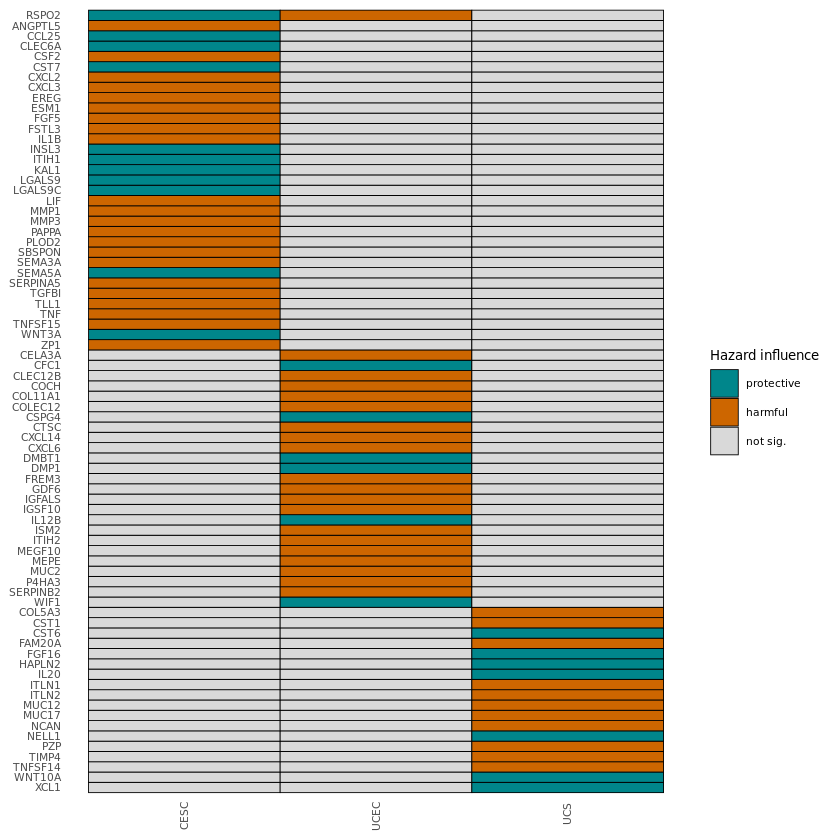

In [29]:
ggplot(data = hm_hazard_df) +
    geom_tile(aes(x = sig_list, y = geneID_f, fill = hazard_infl), color = "black", size = 0.25) +
#     geom_vline(xintercept = c(1.5, 2.5), color = "black", size = 1) +
    theme_classic() +
    scale_fill_manual(
#         values = c("protective" = "steelblue3", "not present" = "lightgray", "harmful" = "firebrick3"),
        values = c("protective" = "turquoise4", "not sig." = "gray85", "harmful" = "darkorange3"),
        breaks = c("protective", "harmful", "not sig.")
    ) +
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.x = element_text(angle = 90, vjust = 0.9/2, hjust = 0.9),
        axis.line = element_blank(),
        axis.ticks = element_blank(),
#         axis.text.y = element_blank(),
    ) +
#     labs(y = "ECM gene", x = "Cohort", fill = "Hazard influence")
    labs(y = NULL, x = NULL, fill = "Hazard influence")

In [30]:
survival_hm <- last_plot()
ggsave(paste0(dirs$figures_dir, "/gene_lists/prognostic_hazard_genes.png"), survival_hm, width = wd_2, height = ht, dpi = dpi)

In [31]:
save(
    list = c("survival_hm", "survival_subcat_hm"),
    file = paste0(dirs$figures_dir, "/saved_obj/survival_hms.RData")
)